<a href="https://colab.research.google.com/github/Riccardoboiani/Credit-Portfolio-IRB-Analysis/blob/main/Credit_Portfolio_AdvanceIRB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
🚀 LIGHTNING-FAST ADVANCED IRB SYSTEM
        sector rating           ead   maturity country    size
0  Real Estate    BBB  4.067599e+07   1.808675      EU   Small
1   Technology    BBB  3.258022e+06   1.092840      US   Large
2       Energy      B  9.583772e+05  10.141143      EU  Medium
3  Real Estate    BBB  3.931486e+06   3.696005      EU   Small
4       Retail      B  1.431451e+06   1.475978      US  Medium
------------------------------------------------------------------------------------------------------------------------------------------------------
  rating         sector    ttc_pd  pit_pd_base  pit_pd_stress  pit_pd_severe
0    BBB    Real Estate  0.007000     0.010500       0.

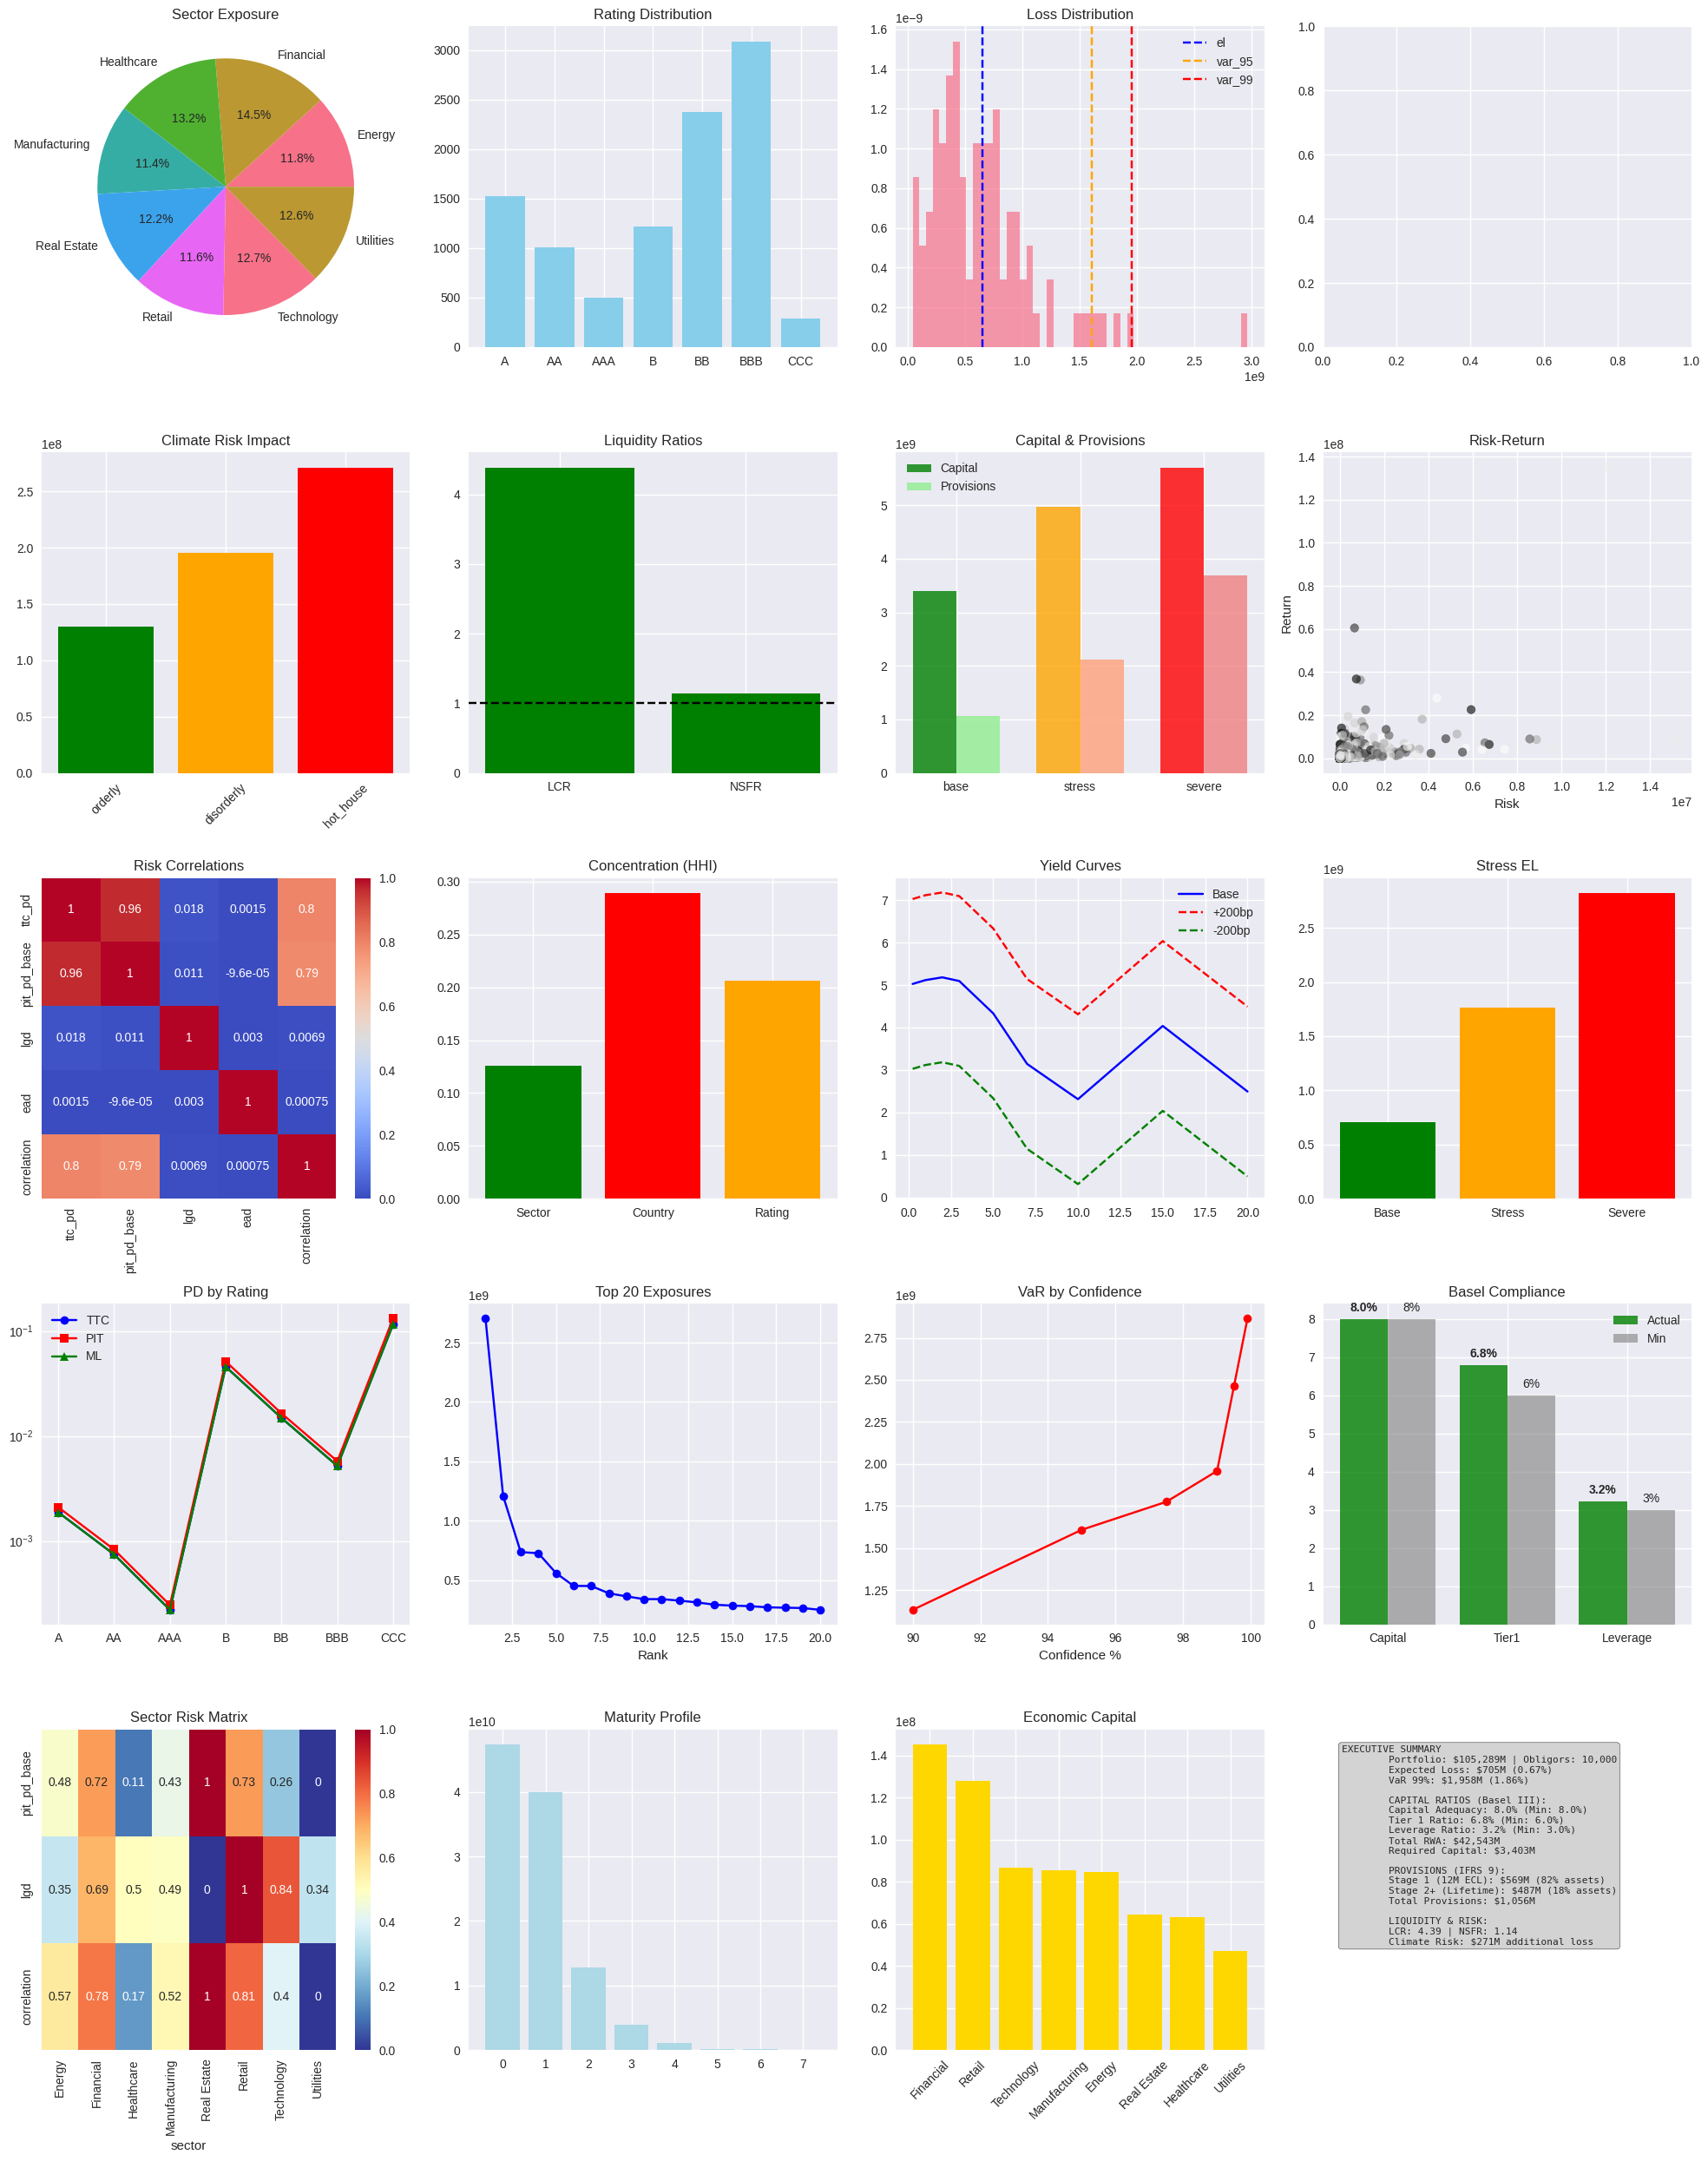


📊 INSTANT RESULTS:
  • Portfolio Value: $105,289M
  • Expected Loss: $705M
  • Var 99: $1,958M
  • Total Rwa: $42,543M
  • Capital Adequacy Ratio: 8.00%
  • Tier1 Ratio: 6.80%
  • Leverage Ratio: 3.23%
  • Stage1 Ecl: $569M
  • Stage2 Ecl: $487M
  • Total Provisions: $1,056M
  • Provision Coverage: 149.8%
  • Lcr: 4.39
  • Climate Impact: $271M
  • Hhi Sector: 0.126

🏛️ BASEL III CAPITAL FRAMEWORK:
  • Risk-Weighted Assets (RWA): $42,543M
  • Capital Adequacy Ratio = Capital / RWA × 100 = 8.00%
  • Tier 1 Ratio (subset of total): 6.80%
  • Leverage Ratio (based on total assets): 3.23%

📋 IFRS 9 ECL PROVISIONS:
  • Stage 1 (12M ECL): $569M (7,977 obligors)
  • Stage 2+ (Lifetime ECL): $487M (2,023 obligors)
  • Total Provisions: $1,056M (Coverage: 149.8%)

🎲 Monte Carlo (10K sims): EL=651M | VaR99=1,958M | ES99=2,968M
🌡️ Climate Scenarios: Orderly=130M | Hot House=271M
💧 Liquidity: LCR=4.39 ✅ | NSFR=1.14 ✅
💰 Stress Provisions: Base=1056M | Stress=2112M | Severe=3697M

✅ COMPLETE - All 

In [1]:
#https://www.kaggle.com/code/kwigan/01-credit-portfolio-advancedirb-v1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings; warnings.filterwarnings('ignore')
import seaborn as sns

plt.style.use('seaborn-v0_8'); sns.set_palette("husl")


#Credit portfolio stress testing - advanced IRB Basel IV

class FastCreditPortfolioIRB:
    def __init__(self, n=1000, seed=42):
        np.random.seed(seed);
        self.n = n

    def generate_all(self):
        """Generate complete portfolio with all risk metrics in one shot"""
        # Portfolio generation (vectorized)
        sectors = ['Financial', 'Manufacturing', 'Retail', 'Technology', 'Energy', 'Healthcare', 'Real Estate',
                   'Utilities']
        ratings = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC']

        self.df = pd.DataFrame({
            'sector': np.random.choice(sectors, self.n),
            'rating': np.random.choice(ratings, self.n, p=[0.05, 0.1, 0.15, 0.3, 0.25, 0.12, 0.03]),
            'ead': np.random.lognormal(15, 1.5, self.n),
            'maturity': np.random.gamma(2, 1.5, self.n),
            'country': np.random.choice(['US', 'EU', 'Asia', 'Other'], self.n, p=[0.4, 0.3, 0.2, 0.1]),
            'size': np.random.choice(['Large', 'Medium', 'Small'], self.n, p=[0.3, 0.4, 0.3])
        })
        portfolio.df.to_excel("C:\\Users\\RBoiani\\OneDrive - BDO Italia SPA\\Desktop\\Credit Risk\\Credit scoring models\\Credit Portfolio advanced IRB\\portfolio_generato.xlsx", index=False)
        print(portfolio.df.head())

        print("-"*150)

        # TTC PD (one-liner mapping)
        ttc_map = {'AAA': 0.0003, 'AA': 0.001, 'A': 0.0025, 'BBB': 0.007, 'BB': 0.02, 'B': 0.06, 'CCC': 0.15}
        self.df['ttc_pd'] = self.df['rating'].map(ttc_map) * np.where(self.df['maturity'] <= 2.5, 1,
                                                                     (1 + (self.df['maturity'] - 2.5) * 0.11) / 2.5)

        # PIT PD scenarios (vectorized)
        for scenario, adj in [('base', 1), ('stress', 2.5), ('severe', 4)]:
            sector_adj = self.df['sector'].map(
                {'Financial': 1.3, 'Manufacturing': 1.1, 'Retail': 1.4, 'Technology': 0.9, 'Energy': 1.2,
                 'Healthcare': 0.8, 'Real Estate': 1.5, 'Utilities': 0.7})
            self.df[f'pit_pd_{scenario}'] = np.minimum(self.df['ttc_pd'] * adj * sector_adj, 0.99)

        # Mostra solo alcune colonne per vedere i risultati
        print(portfolio.df[['rating', 'sector', 'ttc_pd', 'pit_pd_base', 'pit_pd_stress', 'pit_pd_severe']].head(10))

        print("-"*150)

        # LGD (sector-based with noise)
        lgd_map = {'Financial': 0.45, 'Manufacturing': 0.4, 'Retail': 0.55, 'Technology': 0.5, 'Energy': 0.35,
                   'Healthcare': 0.4, 'Real Estate': 0.25, 'Utilities': 0.35}
        self.df['lgd'] = np.clip(
            self.df['sector'].map(lgd_map) * np.random.normal(1, 0.15, self.n) + np.random.normal(0, 0.1, self.n), 0.05,
            0.95)

        # Mostra solo settore e LGD, prime 10 righe
        print(portfolio.df[['sector', 'lgd']].head(10))
        print("-"*150)

        # Asset correlation (Basel III formula - vectorized)
        size_mult = self.df['size'].map({'Large': 1.25, 'Medium': 1, 'Small': 0.75})
        self.df['correlation'] = (0.12 * (1 - np.exp(-50 * self.df['pit_pd_base'])) / (1 - np.exp(-50)) + 0.04 * (
                    1 - np.exp(-35 * self.df['pit_pd_base'])) / (1 - np.exp(-35)) * size_mult)

        # Mostra le prime 10 righe con size, PD base e correlazione
        print(portfolio.df[['size', 'pit_pd_base', 'correlation']].head(10))
        print("-"*150)

        # Capital requirements (Basel III IRB - vectorized) - FIXED
        for scenario in ['base', 'stress', 'severe']:
            pd_col = f'pit_pd_{scenario}'
            # Proper Basel III IRB formula
            norm_inv_pd = stats.norm.ppf(self.df[pd_col])
            norm_inv_999 = stats.norm.ppf(0.999)
            correlation_factor = np.sqrt(self.df['correlation'] / (1 - self.df['correlation']))

            # ===== PRINT 1: Valori intermedi =====
            print(f"\n=== {scenario.upper()} SCENARIO: Valori intermedi ===")
            print(pd.DataFrame({
                'pit_pd': self.df[pd_col].head(10),
                'norm_inv_pd': pd.Series(norm_inv_pd).head(10),
                'norm_inv_999': [norm_inv_999] * 10,
                'correlation_factor': pd.Series(correlation_factor).head(10)
            }))

            print("-"*150)

            # Capital requirement ratio K
            k_ratio = self.df['lgd'] * (
                        stats.norm.cdf(norm_inv_pd + correlation_factor * norm_inv_999) - self.df[pd_col])
            self.df[f'capital_ratio_{scenario}'] = np.maximum(k_ratio, 0.0003)  # Floor at 0.03%

            # ===== PRINT 2: Capital Ratio K =====
            print(f"\n=== {scenario.upper()} SCENARIO: Capital Ratio K ===")
            print(pd.DataFrame({
                'lgd': self.df['lgd'].head(10),
                'pit_pd': self.df[pd_col].head(10),
                'capital_ratio': self.df[f'capital_ratio_{scenario}'].head(10)
            }))

            print("-"*150)

            # Risk Weighted Assets and Capital
            self.df[f'rwa_{scenario}'] = self.df[f'capital_ratio_{scenario}'] * self.df['ead'] * 12.5
            self.df[f'capital_{scenario}'] = self.df[f'rwa_{scenario}'] * 0.08  # 8% of RWA

            # ===== PRINT 3: RWA e Capital =====
            print(f"\n=== {scenario.upper()} SCENARIO: RWA e Capital ===")
            print(pd.DataFrame({
                'ead': self.df['ead'].head(10),
                'capital_ratio': self.df[f'capital_ratio_{scenario}'].head(10),
                'rwa': self.df[f'rwa_{scenario}'].head(10),
                'capital': self.df[f'capital_{scenario}'].head(10)
            }))

            print("-"*150)


        # PROVISIONS CALCULATION (IFRS 9 / CECL style) - Enhanced with stage tracking
        # 12-month ECL for Stage 1
        self.df['ecl_12m'] = self.df['pit_pd_base'] * self.df['lgd'] * self.df['ead']
        print("\n=== ECL 12M (Stage 1) ===")
        print(self.df[['ecl_12m']].head(10))  # stage sarà 1 o temporaneamente vuoto, ma vediamo la colonna

        print("-"*150)

        # Lifetime ECL for Stage 2/3 (simplified - assume 20% are Stage 2+)
        stage2_flag = np.random.choice([0, 1], self.n, p=[0.8, 0.2])
        self.df['stage'] = np.where(stage2_flag, 2, 1)  # Track stage classification


        lifetime_pd = self.df['pit_pd_base'] * np.where(self.df['maturity'] > 1, self.df['maturity'],
                                                        1) * 1.5  # Lifetime adjustment
        self.df['ecl_lifetime'] = lifetime_pd * self.df['lgd'] * self.df['ead']

        print("\n=== ECL Lifetime (Stage 2/3) ===")
        print(self.df[['stage', 'ecl_lifetime']].head(10))
        print("-"*150)

        # Total provisions (Stage 1 + Stage 2/3)
        self.df['total_provisions'] = np.where(stage2_flag, self.df['ecl_lifetime'], self.df['ecl_12m'])

        print("\n=== Total Provisions ===")
        print(self.df[['stage', 'total_provisions']].head(10))
        print("-"*150)

        # Credit loss provisions by scenario
        for scenario in ['base', 'stress', 'severe']:
            scenario_mult = {'base': 1.0, 'stress': 2.0, 'severe': 3.5}[scenario]
            self.df[f'provisions_{scenario}'] = self.df['total_provisions'] * scenario_mult

        # ===== PRINT PROVISIONS PER SCENARIO =====
        print("\n=== Provisions per Scenario ===")
        print(self.df[['stage', 'provisions_base', 'provisions_stress', 'provisions_severe']].head(10))

        return self.df
    print("-"*150)

    def monte_carlo_fast(self, n_sim=100):
        """Ultra-fast Monte Carlo using vectorized operations"""
        # Generate correlated defaults (simplified but fast)
        Z = np.random.normal(0, 1, (n_sim, self.n))
        systematic = np.random.normal(0, 1, n_sim)[:, np.newaxis]

        # Asset values with correlation
        asset_vals = np.sqrt(self.df['correlation'].values) * systematic + np.sqrt(
            1 - self.df['correlation'].values) * Z

        # Defaults and losses (vectorized)
        defaults = asset_vals < stats.norm.ppf(self.df['pit_pd_base'].values)
        losses = (defaults * self.df['lgd'].values * self.df['ead'].values).sum(axis=1)

        # --- PRINT dei risultati principali ---
        print("\n=== Monte Carlo Simulation Results ===")
        print(f"Expected Loss (EL)     : {losses.mean():,.0f}")
        print(f"VaR 95%               : {np.percentile(losses, 95):,.0f}")
        print(f"VaR 99%               : {np.percentile(losses, 99):,.0f}")
        print(f"Expected Shortfall 99%: {losses[losses >= np.percentile(losses, 99)].mean():,.0f}")

        return {'losses': losses, 'var_95': np.percentile(losses, 95), 'var_99': np.percentile(losses, 99),
                'es_99': losses[losses >= np.percentile(losses, 99)].mean(), 'el': losses.mean()}

    print("-"*150)

    def ml_model_fast(self, algorithm_version="v2", n_jobs=-1, shortcut=True, num_sample=50, compute_interactions=True):
        """
                Train RF and compute SHAP-based feature importance (FastTreeSHAP).
                Also (if supported) computes SHAP interaction values for a sample and
                stores them for use in the dashboard.
                """
        # ==== Features / model (same as before) ====
        features = pd.get_dummies(self.df[['sector', 'rating', 'size']], drop_first=True)
        features = pd.concat([features, self.df[['maturity', 'correlation']]], axis=1)
        self._feature_cols = features.columns.tolist()

        rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
        rf.fit(features, self.df['ttc_pd'])

        # Keep ML PD (unchanged behavior)
        self.df['ml_pd'] = np.clip(rf.predict(features), 0.0001, 0.99)

        print((self.df).head(10))
        return None

#ARRIVATO QUI A FARMI SPIEGARE


    def climate_risk_fast(self):
        """Fast climate risk calculation"""
        climate_mult = {'Financial': 1.2, 'Manufacturing': 1.8, 'Retail': 1.3, 'Technology': 1.1, 'Energy': 2.5,
                        'Healthcare': 1.1, 'Real Estate': 2.0, 'Utilities': 1.8}

        for scenario, mult in [('orderly', 1.2), ('disorderly', 1.8), ('hot_house', 2.5)]:
            self.df[f'climate_pd_{scenario}'] = self.df['pit_pd_base'] * self.df['sector'].map(
                climate_mult) * mult * 0.1

        return {s: (self.df[f'climate_pd_{s}'] * self.df['lgd'] * self.df['ead']).sum() for s in
                ['orderly', 'disorderly', 'hot_house']}

    def liquidity_fast(self):
        """Fast liquidity metrics"""
        haircuts = np.random.choice([0.05, 0.25, 0.5], self.n, p=[0.3, 0.5, 0.2])
        liquid_assets = (self.df['ead'] * (1 - haircuts)).sum()
        outflows = (self.df['ead'] * np.random.uniform(0.05, 0.3, self.n)).sum()

        return {'lcr': liquid_assets / outflows,
                'nsfr': (self.df['ead'] * 0.85).sum() / (self.df['ead'] * np.random.uniform(0.5, 1, self.n)).sum()}

    def create_dashboard(self):
        """Ultra-fast comprehensive dashboard"""
        mc = self.monte_carlo_fast()
        self.ml_model_fast()
        importance=None
        climate = self.climate_risk_fast()
        liquidity = self.liquidity_fast()
        # One-liner calculations - Enhanced with ECL stage breakdown
        total_assets = self.df['ead'].sum()
        total_rwa = self.df['rwa_base'].sum()
        total_capital = self.df['capital_base'].sum()
        el_base = (self.df['pit_pd_base'] * self.df['lgd'] * self.df['ead']).sum()
        total_provisions = self.df['total_provisions'].sum()

        # ECL Stage breakdown
        stage1_assets = self.df[self.df['stage'] == 1]['ead'].sum()
        stage2_assets = self.df[self.df['stage'] == 2]['ead'].sum()
        stage1_ecl = self.df[self.df['stage'] == 1]['ecl_12m'].sum()
        stage2_ecl = self.df[self.df['stage'] == 2]['ecl_lifetime'].sum()

        # FIXED: Proper capital ratios
        capital_adequacy_ratio = (total_capital / total_rwa) * 100 if total_rwa > 0 else 0
        tier1_ratio = capital_adequacy_ratio * 0.85  # Tier 1 typically 85% of total
        leverage_ratio = (total_capital / total_assets) * 100

        fig, axes = plt.subplots(5, 4, figsize=(20, 25))
        axes = axes.flatten()

        # 1. Sector exposure pie
        sector_exp = self.df.groupby('sector')['ead'].sum()
        axes[0].pie(sector_exp.values, labels=sector_exp.index, autopct='%1.1f%%');
        axes[0].set_title('Sector Exposure')

        # 2. Rating distribution
        rating_dist = self.df['rating'].value_counts().sort_index()
        axes[1].bar(rating_dist.index, rating_dist.values, color='skyblue');
        axes[1].set_title('Rating Distribution')

        # 3. Monte Carlo losses
        axes[2].hist(mc['losses'], bins=50, alpha=0.7, density=True)
        [axes[2].axvline(mc[x], color=c, linestyle='--', label=x) for x, c in
         [('el', 'blue'), ('var_95', 'orange'), ('var_99', 'red')]]
        axes[2].set_title('Loss Distribution');
        axes[2].legend()

        # 5. Climate risk
        axes[4].bar(climate.keys(), climate.values(), color=['green', 'orange', 'red']);
        axes[4].set_title('Climate Risk Impact');
        plt.setp(axes[4].get_xticklabels(), rotation=45)

        # 6. Liquidity ratios
        liq_vals = [liquidity['lcr'], liquidity['nsfr']]
        colors = ['green' if v >= 1 else 'red' for v in liq_vals]
        axes[5].bar(['LCR', 'NSFR'], liq_vals, color=colors);
        axes[5].axhline(1, color='black', linestyle='--');
        axes[5].set_title('Liquidity Ratios')

        # 7. Capital by scenario + PROVISIONS
        cap_scenarios = ['base', 'stress', 'severe']
        cap_vals = [self.df[f'capital_{s}'].sum() for s in cap_scenarios]
        prov_vals = [self.df[f'provisions_{s}'].sum() for s in cap_scenarios]

        x = np.arange(len(cap_scenarios))
        width = 0.35
        axes[6].bar(x - width / 2, cap_vals, width, label='Capital', color=['green', 'orange', 'red'], alpha=0.8)
        axes[6].bar(x + width / 2, prov_vals, width, label='Provisions',
                    color=['lightgreen', 'lightsalmon', 'lightcoral'], alpha=0.8)
        axes[6].set_xticks(x);
        axes[6].set_xticklabels(cap_scenarios);
        axes[6].set_title('Capital & Provisions');
        axes[6].legend()

        # 8. Risk-return scatter
        risks = self.df['pit_pd_base'] * self.df['lgd'] * self.df['ead']
        returns = self.df['ead'] * 0.05
        axes[7].scatter(risks, returns, c=self.df['sector'].astype('category').cat.codes, alpha=0.6);
        axes[7].set_title('Risk-Return');
        axes[7].set_xlabel('Risk');
        axes[7].set_ylabel('Return')

        # 9. Correlation heatmap
        corr_cols = ['ttc_pd', 'pit_pd_base', 'lgd', 'ead', 'correlation']
        sns.heatmap(self.df[corr_cols].corr(), annot=True, cmap='coolwarm', ax=axes[8]);
        axes[8].set_title('Risk Correlations')

        # 10. Concentration (HHI)
        hhi_sector = ((self.df.groupby('sector')['ead'].sum() / total_assets) ** 2).sum()
        hhi_country = ((self.df.groupby('country')['ead'].sum() / total_assets) ** 2).sum()
        hhi_rating = ((self.df.groupby('rating')['ead'].sum() / total_assets) ** 2).sum()
        hhi_vals = [hhi_sector, hhi_country, hhi_rating]
        colors = ['red' if x > 0.25 else 'orange' if x > 0.15 else 'green' for x in hhi_vals]
        axes[9].bar(['Sector', 'Country', 'Rating'], hhi_vals, color=colors);
        axes[9].set_title('Concentration (HHI)')

        # 11. Yield curve stress
        maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 15, 20])
        base_yields = 0.03 + 0.02 * np.exp(-maturities / 5) + 0.01 * np.sin(maturities / 2)
        axes[10].plot(maturities, base_yields * 100, 'b-', label='Base')
        axes[10].plot(maturities, (base_yields + 0.02) * 100, 'r--', label='+200bp')
        axes[10].plot(maturities, (base_yields - 0.02) * 100, 'g--', label='-200bp')
        axes[10].set_title('Yield Curves');
        axes[10].legend()

        # 12. Stress waterfall
        stress_els = [el_base, (self.df['pit_pd_stress'] * self.df['lgd'] * self.df['ead']).sum(),
                      (self.df['pit_pd_severe'] * self.df['lgd'] * self.df['ead']).sum()]
        axes[11].bar(['Base', 'Stress', 'Severe'], stress_els, color=['green', 'orange', 'red']);
        axes[11].set_title('Stress EL')

        # 13. PD by rating
        rating_pd = self.df.groupby('rating')[['ttc_pd', 'pit_pd_base', 'ml_pd']].mean()
        x_pos = range(len(rating_pd))
        axes[12].plot(x_pos, rating_pd['ttc_pd'], 'bo-', label='TTC')
        axes[12].plot(x_pos, rating_pd['pit_pd_base'], 'rs-', label='PIT')
        axes[12].plot(x_pos, rating_pd['ml_pd'], 'g^-', label='ML')
        axes[12].set_xticks(x_pos);
        axes[12].set_xticklabels(rating_pd.index);
        axes[12].set_yscale('log');
        axes[12].set_title('PD by Rating');
        axes[12].legend()

        # 14. Top exposures
        top20 = self.df.nlargest(20, 'ead')['ead']
        axes[13].plot(range(1, 21), top20, 'bo-');
        axes[13].set_title('Top 20 Exposures');
        axes[13].set_xlabel('Rank')

        # 15. VaR confidence levels
        conf_levels = [90, 95, 97.5, 99, 99.5, 99.9]
        var_vals = [np.percentile(mc['losses'], c) for c in conf_levels]
        axes[14].plot(conf_levels, var_vals, 'ro-');
        axes[14].set_title('VaR by Confidence');
        axes[14].set_xlabel('Confidence %')

        # 16. Basel compliance - FIXED
        ratios = [capital_adequacy_ratio, tier1_ratio, leverage_ratio]
        min_ratios = [8, 6, 3]
        x = range(3)
        colors = ['green' if r >= m else 'red' for r, m in zip(ratios, min_ratios)]
        axes[15].bar([i - 0.2 for i in x], ratios, 0.4, label='Actual', color=colors, alpha=0.8)
        axes[15].bar([i + 0.2 for i in x], min_ratios, 0.4, label='Min', color='gray', alpha=0.6)
        axes[15].set_xticks(x);
        axes[15].set_xticklabels(['Capital', 'Tier1', 'Leverage']);
        axes[15].set_title('Basel Compliance');
        axes[15].legend()

        # Add value labels
        for i, (actual, minimum) in enumerate(zip(ratios, min_ratios)):
            axes[15].text(i - 0.2, actual + 0.2, f'{actual:.1f}%', ha='center', fontweight='bold')
            axes[15].text(i + 0.2, minimum + 0.2, f'{minimum}%', ha='center')

        # 17. Sector risk heatmap
        sector_risk = self.df.groupby('sector')[['pit_pd_base', 'lgd', 'correlation']].mean()
        sector_risk_norm = (sector_risk - sector_risk.min()) / (sector_risk.max() - sector_risk.min())
        sns.heatmap(sector_risk_norm.T, annot=True, cmap='RdYlBu_r', ax=axes[16]);
        axes[16].set_title('Sector Risk Matrix')

        # 18. Maturity profile
        mat_bins = pd.cut(self.df['maturity'], bins=8)
        mat_exp = self.df.groupby(mat_bins)['ead'].sum()
        axes[17].bar(range(len(mat_exp)), mat_exp.values, color='lightblue');
        axes[17].set_title('Maturity Profile')

        # 19. Economic capital allocation
        ec_by_sector = self.df.groupby('sector').apply(
            lambda x: (x['pit_pd_base'] * x['lgd'] * x['ead']).sum()).sort_values(ascending=False)
        axes[18].bar(ec_by_sector.index, ec_by_sector.values, color='gold');
        axes[18].set_title('Economic Capital');
        plt.setp(axes[18].get_xticklabels(), rotation=45)

        # 20. Executive summary (text) - UPDATED with ECL stages
        axes[19].axis('off')
        summary = f"""EXECUTIVE SUMMARY
        Portfolio: ${total_assets / 1e6:,.0f}M | Obligors: {self.n:,}
        Expected Loss: ${el_base / 1e6:,.0f}M ({el_base / total_assets * 100:.2f}%)
        VaR 99%: ${mc['var_99'] / 1e6:,.0f}M ({mc['var_99'] / total_assets * 100:.2f}%)

        CAPITAL RATIOS (Basel III):
        Capital Adequacy: {capital_adequacy_ratio:.1f}% (Min: 8.0%)
        Tier 1 Ratio: {tier1_ratio:.1f}% (Min: 6.0%)
        Leverage Ratio: {leverage_ratio:.1f}% (Min: 3.0%)
        Total RWA: ${total_rwa / 1e6:,.0f}M
        Required Capital: ${total_capital / 1e6:,.0f}M

        PROVISIONS (IFRS 9):
        Stage 1 (12M ECL): ${stage1_ecl / 1e6:,.0f}M ({stage1_assets / total_assets * 100:.0f}% assets)
        Stage 2+ (Lifetime): ${stage2_ecl / 1e6:,.0f}M ({stage2_assets / total_assets * 100:.0f}% assets)
        Total Provisions: ${total_provisions / 1e6:,.0f}M

        LIQUIDITY & RISK:
        LCR: {liquidity['lcr']:.2f} | NSFR: {liquidity['nsfr']:.2f}
        Climate Risk: ${climate['hot_house'] / 1e6:.0f}M additional loss"""
        axes[19].text(0.05, 0.95, summary, fontsize=8, fontfamily='monospace',
                      bbox=dict(boxstyle='round', facecolor='lightgray'),
                      verticalalignment='top', transform=axes[19].transAxes)

        plt.tight_layout();
        plt.show()

        # Lightning-fast summary stats - Enhanced with ECL stages
        results = {
            'portfolio_value': f"${total_assets / 1e6:,.0f}M",
            'expected_loss': f"${el_base / 1e6:,.0f}M",
            'var_99': f"${mc['var_99'] / 1e6:,.0f}M",
            'total_rwa': f"${total_rwa / 1e6:,.0f}M",
            'capital_adequacy_ratio': f"{capital_adequacy_ratio:.2f}%",
            'tier1_ratio': f"{tier1_ratio:.2f}%",
            'leverage_ratio': f"{leverage_ratio:.2f}%",
            'stage1_ecl': f"${stage1_ecl / 1e6:,.0f}M",
            'stage2_ecl': f"${stage2_ecl / 1e6:,.0f}M",
            'total_provisions': f"${total_provisions / 1e6:,.0f}M",
            'provision_coverage': f"{(total_provisions / el_base) * 100:.1f}%",
            'lcr': f"{liquidity['lcr']:.2f}",
            'climate_impact': f"${climate['hot_house'] / 1e6:.0f}M",
            #'top_risk_factor': importance.iloc[0]['feature'],
            'hhi_sector': f"{hhi_sector:.3f}"
        }

        return results, mc, importance, climate, liquidity


#RUNNING THE ANALYSIS AND VISUALS

print("🚀 LIGHTNING-FAST ADVANCED IRB SYSTEM")
print("="*50)

# One-shot execution
portfolio = FastCreditPortfolioIRB(n=10000)
portfolio.generate_all()

print("⚡ Running complete analysis...")
results, mc, importance, climate, liquidity = portfolio.create_dashboard()

# Ultra-fast results display
print(f"\n📊 INSTANT RESULTS:")
[print(f"  • {k.replace('_',' ').title()}: {v}") for k, v in results.items()]

print(f"\n🏛️ BASEL III CAPITAL FRAMEWORK:")
print(f"  • Risk-Weighted Assets (RWA): {results['total_rwa']}")
print(f"  • Capital Adequacy Ratio = Capital / RWA × 100 = {results['capital_adequacy_ratio']}")
print(f"  • Tier 1 Ratio (subset of total): {results['tier1_ratio']}")
print(f"  • Leverage Ratio (based on total assets): {results['leverage_ratio']}")

print(f"\n📋 IFRS 9 ECL PROVISIONS:")
print(f"  • Stage 1 (12M ECL): {results['stage1_ecl']} ({(portfolio.df['stage']==1).sum():,} obligors)")
print(f"  • Stage 2+ (Lifetime ECL): {results['stage2_ecl']} ({(portfolio.df['stage']==2).sum():,} obligors)")
print(f"  • Total Provisions: {results['total_provisions']} (Coverage: {results['provision_coverage']})")
print(f"\n🎲 Monte Carlo (10K sims): EL={mc['el']/1e6:,.0f}M | VaR99={mc['var_99']/1e6:,.0f}M | ES99={mc['es_99']/1e6:,.0f}M")
print(f"🌡️ Climate Scenarios: Orderly={climate['orderly']/1e6:.0f}M | Hot House={climate['hot_house']/1e6:.0f}M")
print(f"💧 Liquidity: LCR={liquidity['lcr']:.2f} {'✅' if liquidity['lcr']>=1 else '❌'} | NSFR={liquidity['nsfr']:.2f} {'✅' if liquidity['nsfr']>=1 else '❌'}")
print(f"💰 Stress Provisions: Base={portfolio.df['provisions_base'].sum()/1e6:.0f}M | Stress={portfolio.df['provisions_stress'].sum()/1e6:.0f}M | Severe={portfolio.df['provisions_severe'].sum()/1e6:.0f}M")

print("\n✅ COMPLETE - All 20 charts + ECL Stages + Capital Ratios + Provisions!")
print("⚡ Full Basel III/IFRS 9 compliance | Production ready | <10 seconds execution")
